![Aircraft Wildlife Strikes2](https://i.postimg.cc/g2ZKpVGT/AIRCRAFT-WILDLIFE-STRIKES-3.png)

![Plane and Birds](https://tinyurl.com/5n79cxst)

## **Introduction**

The project focuses on analyzing aircraft–bird strike incidents and classifying their outcome severity. The data come from the open FAA Wildlife Strikes dataset covering 1990–2024 and describing over 300,000 incidents.

The FAA Wildlife Strikes database provides detailed information on each bird strike — from phase of flight and aircraft parameters to environmental conditions and the final result (scale of a damage).

The aim of this project is to build and compare three classifiers (Logistic Regression, Random Forest, XGBoost) to predict aircraft damage (binary classification: damage vs. no damage), and then assess how balancing the highly imbalanced target class (≈10% damage) affects accuracy, precision, recall, and F1 metrics.

### **Table of Contents**

1. Data import and preliminary cleaning  
2. Exploratory Data Analysis (EDA)  
3. Missing Data Imputation
4. Data preparation  
5. Model training  
6. Evaluation and conclusions  



___
___
## **1 - Data Importing & Preliminary Cleaning**
___
___

### 1.1 - Setting the Environment
___



In [1]:
!pip install -q airportsdata
!pip install -q timezonefinder
!pip install -q pytz
!pip install -q astral

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 912.7/912.7 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 52.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 38.5 MB/s eta 0:00:00


In [2]:
# ——— Data Handling ———
import pandas as pd
import numpy as np

# ——— File Download & Utilities ———
import gdown
from IPython.display import display
from tqdm.auto import tqdm
import os, glob

# ——— Visualization ———
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ——— Geolocation & Time Calculation ———
from airportsdata import load
from timezonefinder import TimezoneFinder
from datetime import datetime
from astral import LocationInfo
from astral.sun import sun
import pytz

# ——— Machine Learning ———
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier


pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

### 1.2 - Data Importing
___

In [3]:
DATA_DIR = "/kaggle/input/faa-wildlife-strikes"

csv_candidates = glob.glob(os.path.join(DATA_DIR, "*.csv"))
assert len(csv_candidates) > 0, "CSV not found in /kaggle/input/faa-wildlife-strikes"
CSV_PATH = csv_candidates[0]

df = pd.read_csv(CSV_PATH, low_memory=False)
df = df[df["INCIDENT_YEAR"] <= 2024]

display(df.drop(columns=['REMARKS']).head())

,INDEX_NR,INCIDENT_DATE,INCIDENT_MONTH,INCIDENT_YEAR,TIME,TIME_OF_DAY,AIRPORT_ID,AIRPORT,AIRPORT_LATITUDE,AIRPORT_LONGITUDE,RUNWAY,STATE,FAAREGION,LOCATION,OPID,OPERATOR,REG,FLT,AIRCRAFT,AMA,AMO,EMA,EMO,AC_CLASS,AC_MASS,TYPE_ENG,NUM_ENGS,ENG_1_POS,ENG_2_POS,ENG_3_POS,ENG_4_POS,PHASE_OF_FLIGHT,HEIGHT,SPEED,DISTANCE,SKY,PRECIPITATION,AOS,COST_REPAIRS,COST_OTHER,COST_REPAIRS_INFL_ADJ,COST_OTHER_INFL_ADJ,INGESTED_OTHER,INDICATED_DAMAGE,DAMAGE_LEVEL,STR_RAD,DAM_RAD,STR_WINDSHLD,DAM_WINDSHLD,STR_NOSE,DAM_NOSE,STR_ENG1,DAM_ENG1,ING_ENG1,STR_ENG2,DAM_ENG2,ING_ENG2,STR_ENG3,DAM_ENG3,ING_ENG3,STR_ENG4,DAM_ENG4,ING_ENG4,STR_PROP,DAM_PROP,STR_WING_ROT,DAM_WING_ROT,STR_FUSE,DAM_FUSE,STR_LG,DAM_LG,STR_TAIL,DAM_TAIL,STR_LGHTS,DAM_LGHTS,STR_OTHER,DAM_OTHER,OTHER_SPECIFY,EFFECT,EFFECT_OTHER,BIRD_BAND_NUMBER,SPECIES_ID,SPECIES,OUT_OF_RANGE_SPECIES,REMAINS_COLLECTED,REMAINS_SENT,WARNED,NUM_SEEN,NUM_STRUCK,SIZE,ENROUTE_STATE,NR_INJURIES,NR_FATALITIES,COMMENTS,REPORTED_NAME,REPORTED_TITLE,SOURCE,PERSON,LUPDATE,TRANSFER
0,608242,1996-06-22,6,1996,NaN,NaN,KSMF,SACRAMENTO INTL,38.69542,-121.59077,NaN,CA,AWP,NaN,UAL,UNITED AIRLINES,NaN,1768,B-737-300,148,24,10.0,1.0,A,4.0,D,2.0,1.0,1.0,NaN,NaN,Take-off Run,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,UNKBM,Unknown bird - medium,0,0,0,Unknown,NaN,1,Medium,NaN,NaN,NaN,/Legacy Record 100001/,REDACTED,REDACTED,Air Transport Report,Air Transport Operations,2007-12-20,0
1,608243,1996-06-26,6,1996,NaN,NaN,KDEN,DENVER INTL AIRPORT,39.85841,-104.667,NaN,CO,ANM,NaN,UAL,UNITED AIRLINES,NaN,1845,B-737-300,148,24,10.0,1.0,A,4.0,D,2.0,1.0,1.0,NaN,NaN,Take-off Run,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,UNKBM,Unknown bird - medium,0,0,0,Unknown,NaN,1,Medium,NaN,NaN,NaN,/Legacy Record 100002/,REDACTED,REDACTED,Air Transport Report,Air Transport Operations,2007-12-20,0
2,608244,1996-07-01,7,1996,NaN,NaN,KOMA,EPPLEY AIRFIELD,41.30252,-95.89417,NaN,NE,ACE,NaN,UAL,UNITED AIRLINES,NaN,306,B-757-200,148,26,34.0,40.0,A,4.0,D,2.0,1.0,1.0,NaN,NaN,Take-off Run,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,N,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,UNKBM,Unknown bird - medium,0,0,0,Unknown,NaN,1,Medium,NaN,NaN,NaN,/Legacy Record 100003/,REDACTED,REDACTED,Air Transport Report,Air Transport Operations,2007-12-20,0
3,608245,1996-07-01,7,1996,NaN,NaN,KIAD,WASHINGTON DULLES INTL ARPT,38.94453,-77.45581,NaN,DC,AEA,NaN,UAL,UNITED AIRLINES,NaN,510,A-320,04A,3,23.0,1.0,A,4.0,D,2.0,1.0,1.0,NaN,NaN,Approach,1000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,N,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,UNKBM,Unknown bird - medium,0,0,0,Unknown,NaN,1,Medium,NaN,NaN,NaN,/Legacy Record 100004/,REDACTED,REDACTED,Air Transport Report,Air Transport Operations,2007-12-20,0
4,608246,1996-07-01,7,1996,NaN,NaN,KLGA,LA GUARDIA ARPT,40.77724,-73.87261,NaN,NY,AEA,NaN,UAL,UNITED AIRLINES,NaN,677,A-320,04A,3,23.0,1.0,A,4.0,D,2.0,1.0,1.0,NaN,NaN,Climb,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,M,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,UNKBM,Unknown bird - medium,0,0,0,Unknown,NaN,1,Medium,NaN,NaN,NaN,/Legacy Record 100005/,REDACTED,REDACTED,Air Transport Report,Air Transport Operations,2007-12-20,0


### 1.3 - Preliminary Cleaning
___

In this section, initial cleaning of the raw dataset is performed. The objective is to isolate the necessary features for the classification model while removing redundant or low-quality columns. The preliminary cleaning is divided into several key steps:
- **Features Filtering:** Selecting only those variables that provide crucial information for the model.
- **Replace Placeholder Values:** Converting placeholder strings (e.g., "Unknown", "ZZZZ") to proper missing values (NaN) for consistent data handling.
- **Further Features Filtering:** Dropping additional columns that carry little value or contain excessive missing data.


#### 1.3.1 - Features Filtering

The original dataset contains numerous variables, including detailed damage measures and aftermath information. Since the focus is on predicting the scale of damage during an incident, the dataset is filtered to include only the essential variables:
- **Target Variables:** e.g., `INDICATED_DAMAGE`
- **Flight Time & Circumstances:** e.g., `INCIDENT_YEAR`, `INCIDENT_MONTH`, `TIME`, `PHASE_OF_FLIGHT`
- **Aircraft Properties & Conditions:** e.g., `AIRCRAFT`, `AC_CLASS`, `HEIGHT`, `SPEED`, etc.

This selection ensures that subsequent analyses concentrate on the most relevant aspects for the classification task.


In [4]:
selected_cols = [
    # Target variables
    'INDICATED_DAMAGE',
    #'DAMAGE_LEVEL',
    # Flight time and circumstances
    'INCIDENT_YEAR',
    'INCIDENT_MONTH',
    'INCIDENT_DATE',
    'TIME',
    'TIME_OF_DAY',
    'PHASE_OF_FLIGHT',
    'HEIGHT',
    'SPEED',
    'DISTANCE',
    # Aircraft properties
    'AIRCRAFT',
    'AC_CLASS',
    'AC_MASS',
    'TYPE_ENG',
    'NUM_ENGS',
    'ENG_1_POS',
    'ENG_2_POS',
    'ENG_3_POS',
    'ENG_4_POS',
    # Weather and environmental conditions
    'SKY',
    'PRECIPITATION',
    'WARNED',
    # Bird characteristics
    'SPECIES',
    'SPECIES_ID',
    'SIZE',
    'NUM_SEEN',
    'NUM_STRUCK',
    # Additional (location/operator)
    'AIRPORT_ID',
    'AIRPORT',
    'STATE',
    'OPERATOR',
    'FAAREGION'
]

aws = df[selected_cols]
aws.head()

,INDICATED_DAMAGE,INCIDENT_YEAR,INCIDENT_MONTH,INCIDENT_DATE,TIME,TIME_OF_DAY,PHASE_OF_FLIGHT,HEIGHT,SPEED,DISTANCE,AIRCRAFT,AC_CLASS,AC_MASS,TYPE_ENG,NUM_ENGS,ENG_1_POS,ENG_2_POS,ENG_3_POS,ENG_4_POS,SKY,PRECIPITATION,WARNED,SPECIES,SPECIES_ID,SIZE,NUM_SEEN,NUM_STRUCK,AIRPORT_ID,AIRPORT,STATE,OPERATOR,FAAREGION
0,0,1996,6,1996-06-22,NaN,NaN,Take-off Run,0.0,NaN,0.0,B-737-300,A,4.0,D,2.0,1.0,1.0,NaN,NaN,NaN,NaN,Unknown,Unknown bird - medium,UNKBM,Medium,NaN,1,KSMF,SACRAMENTO INTL,CA,UNITED AIRLINES,AWP
1,0,1996,6,1996-06-26,NaN,NaN,Take-off Run,0.0,NaN,0.0,B-737-300,A,4.0,D,2.0,1.0,1.0,NaN,NaN,NaN,NaN,Unknown,Unknown bird - medium,UNKBM,Medium,NaN,1,KDEN,DENVER INTL AIRPORT,CO,UNITED AIRLINES,ANM
2,0,1996,7,1996-07-01,NaN,NaN,Take-off Run,0.0,NaN,0.0,B-757-200,A,4.0,D,2.0,1.0,1.0,NaN,NaN,NaN,NaN,Unknown,Unknown bird - medium,UNKBM,Medium,NaN,1,KOMA,EPPLEY AIRFIELD,NE,UNITED AIRLINES,ACE
3,0,1996,7,1996-07-01,NaN,NaN,Approach,1000.0,NaN,NaN,A-320,A,4.0,D,2.0,1.0,1.0,NaN,NaN,NaN,NaN,Unknown,Unknown bird - medium,UNKBM,Medium,NaN,1,KIAD,WASHINGTON DULLES INTL ARPT,DC,UNITED AIRLINES,AEA
4,1,1996,7,1996-07-01,NaN,NaN,Climb,5000.0,NaN,NaN,A-320,A,4.0,D,2.0,1.0,1.0,NaN,NaN,NaN,NaN,Unknown,Unknown bird - medium,UNKBM,Medium,NaN,1,KLGA,LA GUARDIA ARPT,NY,UNITED AIRLINES,AEA


In [5]:
summary_basic = pd.DataFrame({
    'Data type': aws.dtypes,
    'Non-null count': aws.notnull().sum(),
    'Null count': aws.isnull().sum(),
    'Null percentage': (aws.isnull().mean() * 100).round(2),
    'Unique count': aws.nunique(dropna=True)
}, index=aws.columns).T

display(summary_basic)

,INDICATED_DAMAGE,INCIDENT_YEAR,INCIDENT_MONTH,INCIDENT_DATE,TIME,TIME_OF_DAY,PHASE_OF_FLIGHT,HEIGHT,SPEED,DISTANCE,AIRCRAFT,AC_CLASS,AC_MASS,TYPE_ENG,NUM_ENGS,ENG_1_POS,ENG_2_POS,ENG_3_POS,ENG_4_POS,SKY,PRECIPITATION,WARNED,SPECIES,SPECIES_ID,SIZE,NUM_SEEN,NUM_STRUCK,AIRPORT_ID,AIRPORT,STATE,OPERATOR,FAAREGION
Data type,int64,int64,int64,object,object,object,object,float64,float64,float64,object,object,float64,object,float64,float64,float64,float64,float64,object,object,object,object,object,object,object,object,object,object,object,object,object
Non-null count,316823,316823,316823,316823,194392,178083,192970,160041,100401,208005,316823,226542,226425,226061,226160,226136,210318,13451,3514,150769,11914,316823,316823,316823,286163,102658,316148,316817,316823,275883,316820,275883
Null count,0,0,0,0,122431,138740,123853,156782,216422,108818,0,90281,90398,90762,90663,90687,106505,303372,313309,166054,304909,0,0,0,30660,214165,675,6,0,40940,3,40940
Null percentage,0.0,0.0,0.0,0.0,38.64,43.79,39.09,49.49,68.31,34.35,0.0,28.5,28.53,28.65,28.62,28.62,33.62,95.75,98.89,52.41,96.24,0.0,0.0,0.0,9.68,67.6,0.21,0.0,0.0,12.92,0.0,12.92
Unique count,2,35,12,12702,1441,4,12,724,290,226,613,5,5,7,4,7,7,5,4,3,10,3,929,929,3,4,4,2700,2706,67,618,10


#### 1.3.2 - Replace Placeholder Values

In the dataset, missing values are often represented by placeholders such as "Unknown", "ZZZZ", or "UNKNOWN". For uniform handling of missing data throughout the pipeline, these placeholders are replaced with NaN. This conversion facilitates subsequent analysis and model development.


In [6]:
data = []
for col in aws.columns:
    top_values = aws[col].value_counts(dropna=True).head(10).index.tolist()
    data.append({"Column": col, "Top 10 Unique Values": top_values})
result_df = pd.DataFrame(data)
display(result_df)

,Column,Top 10 Unique Values
0,INDICATED_DAMAGE,"[0, 1]"
1,INCIDENT_YEAR,"[2024, 2023, 2019, 2022, 2018, 2021, 2017, 2015, 2014, 2016]"
2,INCIDENT_MONTH,"[8, 9, 7, 10, 5, 6, 4, 11, 3, 12]"
3,INCIDENT_DATE,"[2023-10-05, 2024-10-24, 2018-10-12, 2024-10-07, 2024-07-11, 2024-07-23, 2024-08-22, 2022-10-27, 2023-10-07, 2024-10-01]"
4,TIME,"[ , 08:00, 09:00, 10:00, 21:00, 11:00, 08:30, 07:00, 22:00, 09:30]"
5,TIME_OF_DAY,"[Day, Night, Dusk, Dawn]"
6,PHASE_OF_FLIGHT,"[Approach, Landing Roll, Take-off Run, Climb, En Route, Departure, Descent, Local, Arrival, Taxi]"
7,HEIGHT,"[0.0, 100.0, 50.0, 500.0, 1000.0, 200.0, 300.0, 2000.0, 3000.0, 10.0]"
8,SPEED,"[140.0, 130.0, 120.0, 150.0, 100.0, 135.0, 250.0, 160.0, 180.0, 110.0]"
9,DISTANCE,"[0.0, 1.0, 5.0, 3.0, 2.0, 10.0, 4.0, 15.0, 0.5, 20.0]"


In [7]:
aws.loc[:, "PHASE_OF_FLIGHT"] = aws.loc[:, "PHASE_OF_FLIGHT"].replace("Unknown", np.nan)
aws.loc[:, "WARNED"] = aws.loc[:, "WARNED"].replace("Unknown", np.nan)
aws.loc[:, "AIRPORT"] = aws.loc[:, "AIRPORT"].replace("UNKNOWN", np.nan)
aws.loc[:, "AIRCRAFT"] = aws.loc[:, "AIRCRAFT"].replace("UNKNOWN", np.nan)
aws.loc[:, "AIRPORT_ID"] = aws.loc[:, "AIRPORT_ID"].replace("ZZZZ", np.nan)
aws.loc[:, "OPERATOR"] = aws.loc[:, "OPERATOR"].replace("UNKNOWN", np.nan)

In [8]:
data = []
for col in aws.columns:
    top_values = aws[col].value_counts(dropna=True).head(10).index.tolist()
    data.append({"Column": col, "Top 10 Unique Values": top_values})
result_df = pd.DataFrame(data)
display(result_df)

,Column,Top 10 Unique Values
0,INDICATED_DAMAGE,"[0, 1]"
1,INCIDENT_YEAR,"[2024, 2023, 2019, 2022, 2018, 2021, 2017, 2015, 2014, 2016]"
2,INCIDENT_MONTH,"[8, 9, 7, 10, 5, 6, 4, 11, 3, 12]"
3,INCIDENT_DATE,"[2023-10-05, 2024-10-24, 2018-10-12, 2024-10-07, 2024-07-11, 2024-07-23, 2024-08-22, 2022-10-27, 2023-10-07, 2024-10-01]"
4,TIME,"[ , 08:00, 09:00, 10:00, 21:00, 11:00, 08:30, 07:00, 22:00, 09:30]"
5,TIME_OF_DAY,"[Day, Night, Dusk, Dawn]"
6,PHASE_OF_FLIGHT,"[Approach, Landing Roll, Take-off Run, Climb, En Route, Departure, Descent, Local, Arrival, Taxi]"
7,HEIGHT,"[0.0, 100.0, 50.0, 500.0, 1000.0, 200.0, 300.0, 2000.0, 3000.0, 10.0]"
8,SPEED,"[140.0, 130.0, 120.0, 150.0, 100.0, 135.0, 250.0, 160.0, 180.0, 110.0]"
9,DISTANCE,"[0.0, 1.0, 5.0, 3.0, 2.0, 10.0, 4.0, 15.0, 0.5, 20.0]"


In [9]:
# Compute and display basic summary statistics
summary_basic = pd.DataFrame({
    'Data type': aws.dtypes,
    'Non-null count': aws.notnull().sum(),
    'Null count': aws.isnull().sum(),
    'Null percentage': (aws.isnull().mean() * 100).round(2),
    'Unique count': aws.nunique(dropna=True)
}, index=aws.columns).T

display(summary_basic)

,INDICATED_DAMAGE,INCIDENT_YEAR,INCIDENT_MONTH,INCIDENT_DATE,TIME,TIME_OF_DAY,PHASE_OF_FLIGHT,HEIGHT,SPEED,DISTANCE,AIRCRAFT,AC_CLASS,AC_MASS,TYPE_ENG,NUM_ENGS,ENG_1_POS,ENG_2_POS,ENG_3_POS,ENG_4_POS,SKY,PRECIPITATION,WARNED,SPECIES,SPECIES_ID,SIZE,NUM_SEEN,NUM_STRUCK,AIRPORT_ID,AIRPORT,STATE,OPERATOR,FAAREGION
Data type,int64,int64,int64,object,object,object,object,float64,float64,float64,object,object,float64,object,float64,float64,float64,float64,float64,object,object,object,object,object,object,object,object,object,object,object,object,object
Non-null count,316823,316823,316823,316823,194392,178083,192965,160041,100401,208005,226935,226542,226425,226061,226160,226136,210318,13451,3514,150769,11914,120431,316823,316823,286163,102658,316148,275960,275966,275883,227215,275883
Null count,0,0,0,0,122431,138740,123858,156782,216422,108818,89888,90281,90398,90762,90663,90687,106505,303372,313309,166054,304909,196392,0,0,30660,214165,675,40863,40857,40940,89608,40940
Null percentage,0.0,0.0,0.0,0.0,38.64,43.79,39.09,49.49,68.31,34.35,28.37,28.5,28.53,28.65,28.62,28.62,33.62,95.75,98.89,52.41,96.24,61.99,0.0,0.0,9.68,67.6,0.21,12.9,12.9,12.92,28.28,12.92
Unique count,2,35,12,12702,1441,4,11,724,290,226,612,5,5,7,4,7,7,5,4,3,10,2,929,929,3,4,4,2699,2705,67,617,10


#### 1.3.3 - Further Features Filtering

After replacing placeholder values, additional columns are removed if they:
- Provide redundant or low-value information (e.g., engine positions).
- Exhibit a very high proportion of missing values, making them unsuitable for inclusion in the model (e.g., `PRECIPITATION`, `NUM_SEEN`, `WARNED`).

This step further refines the dataset to focus on the variables that are most informative for the classification task.


In [10]:
columns_to_drop = [
    "ENG_1_POS",
    "ENG_2_POS",
    "ENG_3_POS",
    "ENG_4_POS",
    # "TIME",
    # "TIME_OF_DAY",
    # "PHASE_OF_FLIGHT",
    # "HEIGHT",
    # "SPEED",
    # "DISTANCE",
    # "AC_CLASS",
    # "AC_MASS",
    # "TYPE_ENG",
    # "NUM_ENGS",
    "PRECIPITATION",
    "NUM_SEEN",
    "WARNED"
]

aws= aws.drop(columns=columns_to_drop)

In [11]:
summary_basic = pd.DataFrame({
    'Data type': aws.dtypes,
    'Non-null count': aws.notnull().sum(),
    'Null count': aws.isnull().sum(),
    'Null percentage': (aws.isnull().mean() * 100).round(2),
    'Unique count': aws.nunique(dropna=True)
}, index=aws.columns).T

display(summary_basic)

,INDICATED_DAMAGE,INCIDENT_YEAR,INCIDENT_MONTH,INCIDENT_DATE,TIME,TIME_OF_DAY,PHASE_OF_FLIGHT,HEIGHT,SPEED,DISTANCE,AIRCRAFT,AC_CLASS,AC_MASS,TYPE_ENG,NUM_ENGS,SKY,SPECIES,SPECIES_ID,SIZE,NUM_STRUCK,AIRPORT_ID,AIRPORT,STATE,OPERATOR,FAAREGION
Data type,int64,int64,int64,object,object,object,object,float64,float64,float64,object,object,float64,object,float64,object,object,object,object,object,object,object,object,object,object
Non-null count,316823,316823,316823,316823,194392,178083,192965,160041,100401,208005,226935,226542,226425,226061,226160,150769,316823,316823,286163,316148,275960,275966,275883,227215,275883
Null count,0,0,0,0,122431,138740,123858,156782,216422,108818,89888,90281,90398,90762,90663,166054,0,0,30660,675,40863,40857,40940,89608,40940
Null percentage,0.0,0.0,0.0,0.0,38.64,43.79,39.09,49.49,68.31,34.35,28.37,28.5,28.53,28.65,28.62,52.41,0.0,0.0,9.68,0.21,12.9,12.9,12.92,28.28,12.92
Unique count,2,35,12,12702,1441,4,11,724,290,226,612,5,5,7,4,3,929,929,3,4,2699,2705,67,617,10


### 1.4 - Conclusions
___

In [12]:
complete_rows = aws.dropna().shape[0]
print("Number of rows with complete data:", complete_rows)

total_rows = aws.shape[0]
complete_percentage = (complete_rows / total_rows) * 100
print("Percentage of rows with complete data: {:.2f}%".format(complete_percentage))

Number of rows with complete data: 40072
Percentage of rows with complete data: 12.65%


The preliminary cleaning process reveals that only a small fraction of records contain complete data (approximately 11.6% of rows have no missing values). These findings highlight several challenges:
- A substantial need exists to impute or otherwise handle missing data in critical features.
- Further adjustments may be required in grouping or engineering features based on the available information.

These insights establish the groundwork for the subsequent phases of exploratory data analysis and missing data imputation, ensuring that the model is built upon a robust, cleaned dataset.


___
___
## **2 - EDA**
___
___

This section systematically examines the aircraft wildlife strikes dataset to uncover key patterns and trends. The analysis is based on 10 charts divided into 5 distinct parts:

1. **Accident Trends**  
   - Accident Distribution by Year  
   - Annual Proportion of Accidents with Indicated Damage  
   - Accident Distribution by Month  

2. **Bird Species Distribution**  
   - Treemap of bird species involved in strikes  

3. **Aircraft Types Distribution**  
   - Treemap of aircraft models involved in strikes  

4. **Flight Phase Analysis**  
   - Box plots of HEIGHT, SPEED, and DISTANCE by PHASE_OF_FLIGHT  
   - Accident counts by PHASE_OF_FLIGHT  

5. **Indicated Damages Distribution**  
   - Overall rate of indicated damages  
   - Damage rate by HEIGHT bins  
   - Damage rate by SPEED bins  


### 2.1 - Accident Trends
___

#### 2.1.1 - Accident Distribution by Year

In [13]:
year_counts = aws.groupby("INCIDENT_YEAR").size().reset_index(name="Accidents")
fig1 = px.line(
    year_counts,
    x="INCIDENT_YEAR",
    y="Accidents",
    markers=True,
    title="Accident Distribution by Year",
    labels={"INCIDENT_YEAR": "Year", "Accidents": "Number of Accidents"}
)
fig1.update_layout(title_font_size=26, title_font_family="Arial Black", title_x=0.5)
fig1.update_xaxes(tickmode='linear')
fig1.update_traces(line=dict(width=4, color="#E6B800"), marker=dict(size=10, color="#ff6666"))
fig1.show()

*Accident Distribution by Year*

- Passenger flight numbers increased over the period, but the growth is less pronounced than the surge in recorded accidents.
- This discrepancy may indicate changes in reporting practices or approaches.
- The hypothesis can be further verified with an additional chart.

#### 2.1.2 - Annual Proportion of Accidents with Indicated Damage

In [14]:
year_total = aws.groupby("INCIDENT_YEAR").size().reset_index(name="Total_Incidents")
year_damage = aws[aws["INDICATED_DAMAGE"] == 1].groupby("INCIDENT_YEAR").size().reset_index(name="Damage_Incidents")
merged = pd.merge(year_total, year_damage, on="INCIDENT_YEAR", how="left").fillna(0)
merged["Damage_Pct"] = (merged["Damage_Incidents"] / merged["Total_Incidents"]) * 100
fig2 = px.bar(
    merged,
    x="INCIDENT_YEAR",
    y="Damage_Pct",
    color="INCIDENT_YEAR",
    title="Percentage of Accidents with Indicated Damage by Year",
    labels={"INCIDENT_YEAR": "Year", "Damage_Pct": "Indicated Damage (%)"},
    color_continuous_scale="RdYlGn"
)
fig2.update_layout(
    title_font_size=26,
    title_font_family="Arial Black",
    title_x=0.5,
    xaxis=dict(tickmode='linear')
)
fig2.show()

*Annual Proportion of Accidents with Indicated Damage*

- The trends observed in the annual accident distribution are confirmed.
- The lower proportion of incidents with indicated damage might also be a result of enhanced aircraft safety measures.


#### 2.1.3 - Accident Distribution by Month

In [15]:
accidents_by_month = aws.groupby("INCIDENT_MONTH").size().reset_index(name="Accidents")
accidents_by_month = accidents_by_month.sort_values("INCIDENT_MONTH")
fig3 = px.bar(
    accidents_by_month,
    x="INCIDENT_MONTH",
    y="Accidents",
    title="Accident Distribution by Month",
    labels={"INCIDENT_MONTH": "Month", "Accidents": "Number of Accidents"},
    color="Accidents",
    color_continuous_scale=[(0.0, "#E6B800"), (1.0, "#ff6666")]
)
fig3.update_layout(
    title_font_size=26,
    title_font_family="Arial Black",
    title_x=0.5,
    xaxis=dict(tickmode='linear', tick0=1, dtick=1)
)
fig3.show()

*Accident Distribution by Month*

The monthly distribution of accidents shows a clear seasonal pattern, porbably based on birds habits.


### 2.2 - Bird SPECIES Analysis
___

In [16]:
species_df = aws['SPECIES'].value_counts().reset_index()
species_df.columns = ['Species', 'Count']

fig = px.treemap(
    species_df,
    path=['Species'],
    values='Count',
    title='Bird Species in Wildlife Strikes',
    color='Count',
    color_continuous_scale='Viridis'
)

fig.update_layout(
    title_font_size=26,
    title_font_family="Arial Black",
    title_x=0.5,
    margin=dict(t=50, l=25, r=25, b=25)
)
fig.show()

*Bird Species Analysis*

- The treemap shows a wide range of species, with a large segment corresponding to unidentified or unspecified birds.
- Among the frequently reported species are gulls and doves, suggesting that airports in areas with high activity of these birds are particularly vulnerable to wildlife strikes.
- A significant portion of the available bird information is based solely on size; therefore, further analyses will focus on classifying birds by size rather than by species.


### 2.3 - AIRCRAFT Types Analysis
___

In [17]:
aircraft_counts = aws['AIRCRAFT'].value_counts().reset_index()
aircraft_counts.columns = ['Aircraft', 'Count']

fig = px.treemap(
    aircraft_counts,
    path=['Aircraft'],
    values='Count',
    title='Aircraft Types',
    color='Count',
    color_continuous_scale='Viridis'
)
fig.update_layout(title_font_size=26, title_font_family="Arial Black", title_x=0.5,
                  margin=dict(t=50, l=25, r=25, b=25))
fig.show()

*Aircraft Types Analysis*

- The treemap reveals a broad array of aircraft models, with A320 and B737 being the most common. This is due to their widespread use in passenger aviation and their high prevalence in the airspace.
- In the subsequent study, the focus will be on aircraft parameters such as class, weight, and the number of engines. Where such information is missing, it will be supplemented using data from other entries for these aircraft.


### 2.4 - PHASE OF FLIGHT Analysis
___

#### 2.4.1 - Box Plots for HEIGHT, SPEED, and DISTANCE by PHASE OF FLIGHT

In [18]:
phase_order = ["Departure", "Taxi", "Take-off Run", "Climb", "En Route", "Descent",
               "Approach", "Landing Roll", "Parked", "Arrival", "Local", "Unknown"]

fig = make_subplots(rows=1, cols=3,
                    subplot_titles=("Height by Phase", "Speed by Phase", "Distance by Phase"))
for i, col in enumerate(["HEIGHT", "SPEED", "DISTANCE"]):
    for phase in phase_order:
        data_phase = aws[aws["PHASE_OF_FLIGHT"] == phase]
        if not data_phase.empty:
            fig.add_trace(
                go.Box(y=data_phase[col], name=phase, boxmean=True, boxpoints="outliers"),
                row=1, col=i+1
            )
    fig.update_xaxes(title_text="Phase of Flight", tickangle=-45, row=1, col=i+1)
    fig.update_yaxes(title_text=col, row=1, col=i+1)

fig.update_layout(title_text="Box Plots for HEIGHT, SPEED, and DISTANCE by Phase of Flight",
                  title_font_size=26, title_font_family="Arial Black", title_x=0.5, showlegend=True)
fig.show()

*Box Plots for HEIGHT, SPEED, and DISTANCE by Phase of Flight*

These box plots show the distribution of three key flight parameters—height, speed, and distance—from the airport across various flight phases. The goal is to evaluate if typical value ranges for each phase can be used to impute missing data. Key observations:

- Each phase displays its own characteristic range; for example, height and speed increase during take-off and climb, then decrease during descent and approach.
- The median values for each phase offer a reliable basis for imputing missing entries, reducing the risk of extreme estimates.
- Outliers in some phases (e.g., unusually high speeds during approach) should be reviewed before imputation.
- Overall, the distributions match expected operational behavior, supporting the use of flight phase as a criterion for data imputation.


#### 2.4.2 - Total Accidents Distribution Across PHASE OF FLIGHT

In [19]:
phase_order = ["Departure", "Taxi", "Take-off Run", "Climb", "En Route", "Descent",
               "Approach", "Landing Roll", "Parked", "Arrival", "Local", "Unknown"]

phase_stats_total = aws.groupby("PHASE_OF_FLIGHT").size().reset_index(name="Total")
phase_stats_total["PHASE_OF_FLIGHT"] = pd.Categorical(phase_stats_total["PHASE_OF_FLIGHT"],
                                                       categories=phase_order,
                                                       ordered=True)
phase_stats_total.sort_values("PHASE_OF_FLIGHT", inplace=True)

fig_total = px.bar(
    phase_stats_total,
    x="PHASE_OF_FLIGHT",
    y="Total",
    text="Total",
    labels={"PHASE_OF_FLIGHT": "Flight Phase", "Total": "Total Accidents"},
    title="Total Accidents Distribution Across PHASE OF FLIGHT",
    color="Total",
    color_continuous_scale=["#cc9900", "#ff6666"]
)
fig_total.update_traces(texttemplate="%{text}", textposition="outside")
fig_total.update_layout(title_font_size=26, title_font_family="Arial Black", title_x=0.5)
fig_total.show()

*Total Accidents Distribution Across Flight Phases*

- The bar chart displays the total number of incidents for each flight phase. The highest counts occur in the "Approach" phase, likely due to the lower altitude and reduced speed near airports—a region frequently inhabited by birds.
- A significant number of incidents are also observed during the "Take-off Run", "Climb" and " Landing Roll" phases, where rapid altitude changes elevate the risk of bird strikes.
- Notably, the main cruise phases ("En Route" and "Descent")  shows a low incident count, probably because aircraft operate at altitudes that are generally too high for most birds.


### 2.5 - INDICATED DAMAGES Distribution Analysis
___

#### 2.5.1 - Percent of INDICATED DAMAGES Distribution Across PHASE OF FLIGHT

In [20]:
phase_order = ["Departure", "Taxi", "Take-off Run", "Climb", "En Route", "Descent",
               "Approach", "Landing Roll", "Parked", "Arrival", "Local", "Unknown"]

phase_stats = aws.groupby("PHASE_OF_FLIGHT", observed=True)["INDICATED_DAMAGE"]\
                 .agg(total='count', damage='sum').reset_index()
phase_stats["Damage_Pct"] = (phase_stats["damage"] / phase_stats["total"]) * 100
phase_stats["PHASE_OF_FLIGHT"] = pd.Categorical(phase_stats["PHASE_OF_FLIGHT"],
                                                categories=phase_order,
                                                ordered=True)
phase_stats.sort_values("PHASE_OF_FLIGHT", inplace=True)

fig_phase = px.bar(
    phase_stats,
    x="PHASE_OF_FLIGHT",
    y="Damage_Pct",
    text="Damage_Pct",
    labels={"PHASE_OF_FLIGHT": "Flight Phase", "Damage_Pct": "Indicated Damages (%)"},
    title="Percentage of INDICATED DAMAGES Distribution Across PHASE OF FLIGHT",
    color="Damage_Pct",
    color_continuous_scale=["#cc9900", "#ff6666"]
)
fig_phase.update_traces(texttemplate="%{text:.2f}%", textposition="outside")
fig_phase.update_layout(title_font_size=26, title_font_family="Arial Black", title_x=0.5)
fig_phase.show()

*Percent of INDICATED DAMAGES Distribution Across PHASE OF FLIGHT*

- In the En Route and Descent phases, although incidents account for only about 1.2% and 0.5% of all accidents, they tend to result in significant damage due to the high speed of the aircraft.
- The Climb phase combines both a high frequency of incidents and a considerable percentage of damages, suggesting that aircraft are particularly vulnerable during ascent.
- The phases with the highest incident counts (Take-off Run, Approach, Landing Roll) exhibit a lower percentage of severe damages, likely due to lower speeds and more controlled operating conditions.
- Despite the lower proportion of incidents in the En Route and Descent phases, the damage outcomes are more pronounced due to the high speeds, whereas the Climb phase has both a high number of incidents and a high damage rate, while phases with the most incidents show a lower rate of severe damages.


#### 2.5.2 - Percent of INDICATED DAMAGES Distribution by HEIGHT

In [21]:
df_h = aws.dropna(subset=["HEIGHT", "INDICATED_DAMAGE"]).copy()
bins = pd.qcut(df_h["HEIGHT"], q=15, duplicates="drop", retbins=True)[1]
labels = [f"{bins[i]:.2f} – {bins[i+1]:.2f}" for i in range(len(bins)-1)]
df_h["Height_Range"] = pd.qcut(df_h["HEIGHT"], q=15, labels=labels, duplicates="drop")
agg = df_h.groupby("Height_Range")["INDICATED_DAMAGE"].agg(total='count', damage='sum').reset_index()
agg["Damage_Pct"] = (agg["damage"] / agg["total"]) * 100

fig_height = px.bar(
    agg,
    x="Height_Range",
    y="Damage_Pct",
    text="Damage_Pct",
    labels={"Height_Range": "Height Range", "Damage_Pct": "Indicated Damages (%)"},
    title="Percentage of INDICATED DAMAGES by HEIGHT",
    color="Damage_Pct",
    color_continuous_scale=["#cc9900", "#ff6666"]
)
fig_height.update_layout(title_font_size=26, title_font_family="Arial Black", title_x=0.5)
fig_height.update_traces(texttemplate="%{text:.2f}%", textposition="outside")
fig_height.show()

*Percentage of INDICATED DAMAGES by HEIGHT*

- The height ranges are based on quantiles, meaning that the intervals are not of equal width but are chosen to split the data into roughly equal-sized groups.
- At first glance, one might expect severe damages to increase with height; however, the chart remains fairly "flat." This is due to the wide spread of height values in the flight phases with the highest percentage of damages (e.g., En Route), which dilutes any clear relationship.
- In other words, even though some height intervals show a higher percentage of incidents with damages, the high variability in those phases prevents a distinct trend from emerging. In practice, height alone does not determine the extent of the damages as clearly as a simple correlation might suggest.


#### 2.5.3 - Percent of INDICATED DAMAGES Distribution by SPEED

In [22]:
df_s = aws.dropna(subset=["SPEED", "INDICATED_DAMAGE"]).copy()
bins_s = pd.qcut(df_s["SPEED"], q=9, duplicates="drop", retbins=True)[1]
labels_s = [f"{bins_s[i]:.2f} – {bins_s[i+1]:.2f}" for i in range(len(bins_s)-1)]
df_s["Speed_Range"] = pd.qcut(df_s["SPEED"], q=9, labels=labels_s, duplicates="drop")
agg_s = df_s.groupby("Speed_Range")["INDICATED_DAMAGE"].agg(total='count', damage='sum').reset_index()
agg_s["Damage_Pct"] = (agg_s["damage"] / agg_s["total"]) * 100

fig_speed = px.bar(
    agg_s,
    x="Speed_Range",
    y="Damage_Pct",
    text="Damage_Pct",
    labels={"Speed_Range": "Speed Range", "Damage_Pct": "Indicated Damages (%)"},
    title="Percentage of INDICATED DAMAGES by SPEED",
    color="Damage_Pct",
    color_continuous_scale=["#cc9900", "#ff6666"]
)
fig_speed.update_layout(title_font_size=26, title_font_family="Arial Black", title_x=0.5)
fig_speed.update_traces(texttemplate="%{text:.2f}%", textposition="outside")
fig_speed.show()

*Percentage of INDICATED DAMAGES by SPEED*

- At very high speeds, as expected, any bird strike results in severe damages due to the large kinetic energy.
- An unusually high damage rate at low speeds raises concerns – it may indicate reporting errors or incorrect data entries.
- These discrepancies suggest the need for thorough validation and cleaning of speed data to eliminate anomalies and ensure reliable results.


___
___
## **3 - Missing Data Imputation**
___
___

As part of filling in missing data, the following actions were planned:

- **Derive** **TIME_OF_DAY** from local sunrise/sunset, classifying each incident as Dawn, Day, Dusk or Night.  
- **Impute** **DISTANCE** with the median for each phase of flight; **SPEED** and **HEIGHT** with the median for each (phase × aircraft class) group.  
- **Label** missing **SKY** entries for night-time incidents as “NightSky.”  
- **Collapse** **SIZE** into three categories (Small, Medium, Large), leaving any unknown sizes unchanged.  
- **Drop** any rows that still contain missing values to ensure a complete dataset.  

In [23]:
summary_basic = pd.DataFrame({
    'Data type': aws.dtypes,
    'Non-null count': aws.notnull().sum(),
    'Null count': aws.isnull().sum(),
    'Null percentage': (aws.isnull().mean() * 100).round(2),
    'Unique count': aws.nunique(dropna=True)
}, index=aws.columns).T

display(summary_basic)

,INDICATED_DAMAGE,INCIDENT_YEAR,INCIDENT_MONTH,INCIDENT_DATE,TIME,TIME_OF_DAY,PHASE_OF_FLIGHT,HEIGHT,SPEED,DISTANCE,AIRCRAFT,AC_CLASS,AC_MASS,TYPE_ENG,NUM_ENGS,SKY,SPECIES,SPECIES_ID,SIZE,NUM_STRUCK,AIRPORT_ID,AIRPORT,STATE,OPERATOR,FAAREGION
Data type,int64,int64,int64,object,object,object,object,float64,float64,float64,object,object,float64,object,float64,object,object,object,object,object,object,object,object,object,object
Non-null count,316823,316823,316823,316823,194392,178083,192965,160041,100401,208005,226935,226542,226425,226061,226160,150769,316823,316823,286163,316148,275960,275966,275883,227215,275883
Null count,0,0,0,0,122431,138740,123858,156782,216422,108818,89888,90281,90398,90762,90663,166054,0,0,30660,675,40863,40857,40940,89608,40940
Null percentage,0.0,0.0,0.0,0.0,38.64,43.79,39.09,49.49,68.31,34.35,28.37,28.5,28.53,28.65,28.62,52.41,0.0,0.0,9.68,0.21,12.9,12.9,12.92,28.28,12.92
Unique count,2,35,12,12702,1441,4,11,724,290,226,612,5,5,7,4,3,929,929,3,4,2699,2705,67,617,10


### 3.1 - Imputation of TIME / TIME_OF_DAY
___

Due to a significant amount of missing entries in the time information, the decision was made to simplify this variable by focusing on "time of day" rather than the exact clock time. The rationale is as follows:

- The specific clock time can represent either day or night depending on factors such as the date and geographical location (latitude and altitude).  
- The "time of day" information is critical both for detecting bird presence and for understanding birds' diurnal behavior, thereby providing more relevant insight than the exact time.  
- Accordingly, the "time of day" variable will be derived for records that contain both time and airport information, by combining geolocation data with sun time calculations.


#### 3.1.1 – Summary of Missing Values in TIME and TIME_OF_DAY

In [24]:
both = aws["TIME"].notnull() & aws["TIME_OF_DAY"].notnull()
time_only = aws["TIME"].notnull() & aws["TIME_OF_DAY"].isnull()
tod_only = aws["TIME"].isnull() & aws["TIME_OF_DAY"].notnull()
neither = aws["TIME"].isnull() & aws["TIME_OF_DAY"].isnull()

print("Records with both TIME and TIME_OF_DAY:", both.sum())
print("Records with TIME only:", time_only.sum())
print("Records with TIME_OF_DAY only:", tod_only.sum())
print("Records with neither TIME nor TIME_OF_DAY:", neither.sum())

Records with both TIME and TIME_OF_DAY: 142938
Records with TIME only: 51454
Records with TIME_OF_DAY only: 35145
Records with neither TIME nor TIME_OF_DAY: 87286


#### 3.1.2 – Extract Subset for TIME_OF_DAY Imputation

In [25]:
subset_impute = aws[aws["TIME_OF_DAY"].isnull() & aws["TIME"].notnull() & aws["AIRPORT_ID"].notnull()].copy()

#### 3.1.3 – Retrieve Airport Coordinates for the Subset

In [26]:
tf = TimezoneFinder()

airports_iata = load('IATA')
airports_icao = load('ICAO')

def get_airport_coords(code: str):
    """
    Returns (lat, lon) for code IATA/ICAO.
    """
    if pd.isna(code):
        return np.nan, np.nan

    code = str(code).strip().upper()
    rec = airports_iata.get(code) or airports_icao.get(code)
    if rec is None:
        return np.nan, np.nan

    return rec['lat'], rec['lon']

def fetch_coords(row):
    code = row["AIRPORT_ID"]
    lat, lon = get_airport_coords(code)
    return pd.Series([lat, lon], index=["LAT", "LON"])

subset_impute[["LAT", "LON"]] = subset_impute.apply(fetch_coords, axis=1)
subset_impute = subset_impute.dropna(subset=["LAT", "LON"])
display(subset_impute[["INCIDENT_DATE", "TIME", "TIME_OF_DAY", "AIRPORT_ID", "AIRPORT", "LAT", "LON"]].head())

,INCIDENT_DATE,TIME,TIME_OF_DAY,AIRPORT_ID,AIRPORT,LAT,LON
1782,1991-10-22,06:45,NaN,KDBQ,DUBUQUE REGIONAL ARPT,42.40200,-90.70947
8503,1993-12-26,19:00,NaN,KLGA,LA GUARDIA ARPT,40.77725,-73.87261
11986,1998-12-14,17:07,NaN,KEUG,MAHLON SWEET FLD,44.12458,-123.21197
13945,1998-01-21,17:45,NaN,KSMF,SACRAMENTO INTL,38.69544,-121.59078
16314,1999-10-14,21:55,NaN,KBIL,BILLINGS LOGAN INTL,45.80785,-108.54354


#### 3.1.4 – Compute Sun Times Based on Geolocation

In [27]:
def compute_sun_times_local(row):
    try:
        lat = float(row["LAT"])
        lon = float(row["LON"])
    except Exception:
        return pd.Series([np.nan, np.nan, np.nan, np.nan], index=["Dawn", "Sunrise", "Sunset", "Dusk"])
    try:
        inc_date = datetime.strptime(row["INCIDENT_DATE"], "%Y-%m-%d")
    except Exception:
        return pd.Series([np.nan, np.nan, np.nan, np.nan], index=["Dawn", "Sunrise", "Sunset", "Dusk"])
    tz_str = tf.timezone_at(lat=lat, lng=lon) or "UTC"
    local_tz = pytz.timezone(tz_str)
    loc = LocationInfo(name="Airport", region="", timezone=tz_str, latitude=lat, longitude=lon)
    try:
        s = sun(loc.observer, date=inc_date, tzinfo=local_tz)
        dawn = s.get("dawn").strftime("%H:%M") if s.get("dawn") else np.nan
        sunrise = s.get("sunrise").strftime("%H:%M") if s.get("sunrise") else np.nan
        sunset = s.get("sunset").strftime("%H:%M") if s.get("sunset") else np.nan
        dusk = s.get("dusk").strftime("%H:%M") if s.get("dusk") else np.nan
    except Exception:
        dawn, sunrise, sunset, dusk = np.nan, np.nan, np.nan, np.nan
    return pd.Series([dawn, sunrise, sunset, dusk], index=["Dawn", "Sunrise", "Sunset", "Dusk"])

time_airport_local = subset_impute.copy()
time_airport_local[["Dawn", "Sunrise", "Sunset", "Dusk"]] = time_airport_local.apply(compute_sun_times_local, axis=1)
display(time_airport_local[["INCIDENT_DATE", "TIME", "AIRPORT_ID", "LAT", "LON", "Dawn", "Sunrise", "Sunset", "Dusk"]].head())

,INCIDENT_DATE,TIME,AIRPORT_ID,LAT,LON,Dawn,Sunrise,Sunset,Dusk
1782,1991-10-22,06:45,KDBQ,42.40200,-90.70947,06:54,07:23,18:10,18:39
8503,1993-12-26,19:00,KLGA,40.77725,-73.87261,06:47,07:18,16:33,17:05
11986,1998-12-14,17:07,KEUG,44.12458,-123.21197,07:06,07:40,16:34,17:08
13945,1998-01-21,17:45,KSMF,38.69544,-121.59078,06:51,07:20,17:15,17:44
16314,1999-10-14,21:55,KBIL,45.80785,-108.54354,06:58,07:29,18:30,19:00


#### 3.1.5 – Compute Extended Time Boundaries

In [28]:
def compute_extended_boundaries_new(row):
    base_date = "1900-01-01 "
    try:
        dawn_dt = datetime.strptime(base_date + str(row["Dawn"]).strip(), "%Y-%m-%d %H:%M")
        sunrise_dt = datetime.strptime(base_date + str(row["Sunrise"]).strip(), "%Y-%m-%d %H:%M")
        sunset_dt = datetime.strptime(base_date + str(row["Sunset"]).strip(), "%Y-%m-%d %H:%M")
        dusk_dt = datetime.strptime(base_date + str(row["Dusk"]).strip(), "%Y-%m-%d %H:%M")
    except Exception:
        return pd.Series([np.nan, np.nan], index=["Dawn_End", "Dusk_Begin"])
    diff_dawn = sunrise_dt - dawn_dt
    diff_dusk = dusk_dt - sunset_dt
    dawn_end = sunrise_dt + diff_dawn
    dusk_begin = sunset_dt - diff_dusk
    return pd.Series([dawn_end.strftime("%H:%M"), dusk_begin.strftime("%H:%M")], index=["Dawn_End", "Dusk_Begin"])

time_airport_local[["Dawn_End", "Dusk_Begin"]] = time_airport_local.apply(compute_extended_boundaries_new, axis=1)
display(time_airport_local[["INCIDENT_DATE", "TIME", "AIRPORT_ID", "Dawn", "Sunrise", "Dawn_End", "Dusk_Begin", "Sunset", "Dusk"]].head())

,INCIDENT_DATE,TIME,AIRPORT_ID,Dawn,Sunrise,Dawn_End,Dusk_Begin,Sunset,Dusk
1782,1991-10-22,06:45,KDBQ,06:54,07:23,07:52,17:41,18:10,18:39
8503,1993-12-26,19:00,KLGA,06:47,07:18,07:49,16:01,16:33,17:05
11986,1998-12-14,17:07,KEUG,07:06,07:40,08:14,16:00,16:34,17:08
13945,1998-01-21,17:45,KSMF,06:51,07:20,07:49,16:46,17:15,17:44
16314,1999-10-14,21:55,KBIL,06:58,07:29,08:00,18:00,18:30,19:00


#### 3.1.6 – Classify and Impute TIME_OF_DAY

In [29]:
def classify_time_of_day_new(row):
    base_date = "1900-01-01 "
    try:
        rec_time = datetime.strptime(base_date + str(row["TIME"]).strip(), "%Y-%m-%d %H:%M")
        dawn_time = datetime.strptime(base_date + str(row["Dawn"]).strip(), "%Y-%m-%d %H:%M")
        dawn_end = datetime.strptime(base_date + str(row["Dawn_End"]).strip(), "%Y-%m-%d %H:%M")
        dusk_begin = datetime.strptime(base_date + str(row["Dusk_Begin"]).strip(), "%Y-%m-%d %H:%M")
        dusk_time = datetime.strptime(base_date + str(row["Dusk"]).strip(), "%Y-%m-%d %H:%M")
    except Exception:
        return np.nan
    if rec_time < dawn_time:
        return "Night"
    elif dawn_time <= rec_time < dawn_end:
        return "Dawn"
    elif dawn_end <= rec_time <= dusk_begin:
        return "Day"
    elif dusk_begin < rec_time <= dusk_time:
        return "Dusk"
    else:
        return "Night"

time_airport_local["TIME_OF_DAY"] = time_airport_local.apply(classify_time_of_day_new, axis=1)
display(time_airport_local[["INCIDENT_DATE", "TIME", "TIME_OF_DAY", "Dawn", "Sunrise", "Dawn_End", "Dusk_Begin", "Sunset", "Dusk"]].head())

aws.loc[time_airport_local.index, "TIME_OF_DAY"] = time_airport_local["TIME_OF_DAY"]

,INCIDENT_DATE,TIME,TIME_OF_DAY,Dawn,Sunrise,Dawn_End,Dusk_Begin,Sunset,Dusk
1782,1991-10-22,06:45,Night,06:54,07:23,07:52,17:41,18:10,18:39
8503,1993-12-26,19:00,Night,06:47,07:18,07:49,16:01,16:33,17:05
11986,1998-12-14,17:07,Dusk,07:06,07:40,08:14,16:00,16:34,17:08
13945,1998-01-21,17:45,Night,06:51,07:20,07:49,16:46,17:15,17:44
16314,1999-10-14,21:55,Night,06:58,07:29,08:00,18:00,18:30,19:00


In [30]:
summary_basic = pd.DataFrame({
    'Data type': aws.dtypes,
    'Non-null count': aws.notnull().sum(),
    'Null count': aws.isnull().sum(),
    'Null percentage': (aws.isnull().mean() * 100).round(2),
    'Unique count': aws.nunique(dropna=True)
}, index=aws.columns).T

display(summary_basic)

,INDICATED_DAMAGE,INCIDENT_YEAR,INCIDENT_MONTH,INCIDENT_DATE,TIME,TIME_OF_DAY,PHASE_OF_FLIGHT,HEIGHT,SPEED,DISTANCE,AIRCRAFT,AC_CLASS,AC_MASS,TYPE_ENG,NUM_ENGS,SKY,SPECIES,SPECIES_ID,SIZE,NUM_STRUCK,AIRPORT_ID,AIRPORT,STATE,OPERATOR,FAAREGION
Data type,int64,int64,int64,object,object,object,object,float64,float64,float64,object,object,float64,object,float64,object,object,object,object,object,object,object,object,object,object
Non-null count,316823,316823,316823,316823,194392,206561,192965,160041,100401,208005,226935,226542,226425,226061,226160,150769,316823,316823,286163,316148,275960,275966,275883,227215,275883
Null count,0,0,0,0,122431,110262,123858,156782,216422,108818,89888,90281,90398,90762,90663,166054,0,0,30660,675,40863,40857,40940,89608,40940
Null percentage,0.0,0.0,0.0,0.0,38.64,34.8,39.09,49.49,68.31,34.35,28.37,28.5,28.53,28.65,28.62,52.41,0.0,0.0,9.68,0.21,12.9,12.9,12.92,28.28,12.92
Unique count,2,35,12,12702,1441,4,11,724,290,226,612,5,5,7,4,3,929,929,3,4,2699,2705,67,617,10


As a result of these operations, 27,478 entries have been successfully imputed with time-of-day information.

### 3.2 - Imputation of AIRCRAFT / AC_CLASS + AC_MASS + TYPE_ENG + NUM_ENGS
___

Information about the parameters of the aircraft is missing

- Need to check if it is possible to retrieve aircraft parameters using the information assigned to the model from another event

In [31]:
missing_ac_class = aws[aws["AC_CLASS"].isnull() & aws["AIRCRAFT"].notnull()]

aircraft_counts = missing_ac_class["AIRCRAFT"].value_counts(dropna=False)

print("Unique values in 'AIRCRAFT' with missing 'AC_CLASS' value and their counts:")
print(aircraft_counts)

Unique values in 'AIRCRAFT' with missing 'AC_CLASS' value and their counts:
AIRCRAFT
EXPERIMENTAL             330
MILITARY                  29
DRONE                     28
Unknown                    1
BOMBARDIER                 1
CL-600-2C10 / CRJ 700      1
B767-200                   1
AW139                      1
Embraer 175                1
Name: count, dtype: int64


It turns out that the rows with missing information on the aricraft parameter are due to unusual and repetitive types of aircraft, and it is impossible to complete this data

### 3.3 - Imputation of PHASE_OF_FLIGHT + AC_CLASS / DISTANCE + HEIGHT + SPEED
___

Large deficiencies in flight parameters

- Need to see if it is possible to determine DISTANCE based on PHASE_OF_FLIGHT and vice versa

- It is also necessary to try to determine HEIGHT and SPEED on the PHASE_OF_FLIGHT and AC_CLASS substrate

In [32]:
# --- Completing DISTANCE ---
mask_missing = aws["PHASE_OF_FLIGHT"].notnull() & aws["DISTANCE"].isnull()
missing_before = mask_missing.sum()
total_records = len(aws)

print(f"Before imputation: {missing_before} missing values out of {total_records} records.")

median_distance = aws.loc[aws["DISTANCE"].notnull()].groupby("PHASE_OF_FLIGHT")["DISTANCE"].median()

aws_filled = aws.copy()
aws_filled.loc[mask_missing, "DISTANCE"] = aws_filled.loc[mask_missing, "PHASE_OF_FLIGHT"].map(median_distance)

mask_missing_after = aws_filled["PHASE_OF_FLIGHT"].notnull() & aws_filled["DISTANCE"].isnull()
missing_after = mask_missing_after.sum()

imputed = missing_before - missing_after

print(f"After imputation: {missing_after} missing values out of {total_records} records.")
print(f"Number of values imputed: {imputed}")

aws = aws_filled.copy()

Before imputation: 73175 missing values out of 316823 records.
After imputation: 0 missing values out of 316823 records.
Number of values imputed: 73175


In [33]:
# --- Completing  HEIGHT and SPEED ---
aws_imputed = aws.copy()

mask_speed = aws_imputed["PHASE_OF_FLIGHT"].notnull() & aws_imputed["AC_CLASS"].notnull() & aws_imputed["SPEED"].isnull()
median_speed = aws_imputed.groupby(["PHASE_OF_FLIGHT", "AC_CLASS"])["SPEED"].transform("median")
aws_imputed.loc[mask_speed, "SPEED"] = median_speed[mask_speed]

mask_height = aws_imputed["PHASE_OF_FLIGHT"].notnull() & aws_imputed["AC_CLASS"].notnull() & aws_imputed["HEIGHT"].isnull()
median_height = aws_imputed.groupby(["PHASE_OF_FLIGHT", "AC_CLASS"])["HEIGHT"].transform("median")

aws_imputed.loc[mask_height, "HEIGHT"] = median_height[mask_height]
total_records = len(aws)

speed_missing_before = aws["SPEED"].isnull().sum()
speed_missing_after  = aws_imputed["SPEED"].isnull().sum()
height_missing_before = aws["HEIGHT"].isnull().sum()
height_missing_after  = aws_imputed["HEIGHT"].isnull().sum()

imputed_speed  = speed_missing_before - speed_missing_after
imputed_height = height_missing_before - height_missing_after

print("=== SPEED Imputation Summary ===")
print(f"SPEED missing before imputation: {speed_missing_before}")
print(f"SPEED missing after imputation:  {speed_missing_after}")
print(f"Number of SPEED values imputed:  {imputed_speed}")
print("\n=== HEIGHT Imputation Summary ===")
print(f"HEIGHT missing before imputation: {height_missing_before}")
print(f"HEIGHT missing after imputation:  {height_missing_after}")
print(f"Number of HEIGHT values imputed:  {imputed_height}")

aws = aws_imputed.copy()

=== SPEED Imputation Summary ===
SPEED missing before imputation: 216422
SPEED missing after imputation:  125210
Number of SPEED values imputed:  91212

=== HEIGHT Imputation Summary ===
HEIGHT missing before imputation: 156782
HEIGHT missing after imputation:  127504
Number of HEIGHT values imputed:  29278


In [34]:
summary_basic = pd.DataFrame({
    'Data type': aws.dtypes,
    'Non-null count': aws.notnull().sum(),
    'Null count': aws.isnull().sum(),
    'Null percentage': (aws.isnull().mean() * 100).round(2),
    'Unique count': aws.nunique(dropna=True)
}, index=aws.columns).T

display(summary_basic)

,INDICATED_DAMAGE,INCIDENT_YEAR,INCIDENT_MONTH,INCIDENT_DATE,TIME,TIME_OF_DAY,PHASE_OF_FLIGHT,HEIGHT,SPEED,DISTANCE,AIRCRAFT,AC_CLASS,AC_MASS,TYPE_ENG,NUM_ENGS,SKY,SPECIES,SPECIES_ID,SIZE,NUM_STRUCK,AIRPORT_ID,AIRPORT,STATE,OPERATOR,FAAREGION
Data type,int64,int64,int64,object,object,object,object,float64,float64,float64,object,object,float64,object,float64,object,object,object,object,object,object,object,object,object,object
Non-null count,316823,316823,316823,316823,194392,206561,192965,189319,191613,281180,226935,226542,226425,226061,226160,150769,316823,316823,286163,316148,275960,275966,275883,227215,275883
Null count,0,0,0,0,122431,110262,123858,127504,125210,35643,89888,90281,90398,90762,90663,166054,0,0,30660,675,40863,40857,40940,89608,40940
Null percentage,0.0,0.0,0.0,0.0,38.64,34.8,39.09,40.24,39.52,11.25,28.37,28.5,28.53,28.65,28.62,52.41,0.0,0.0,9.68,0.21,12.9,12.9,12.92,28.28,12.92
Unique count,2,35,12,12702,1441,4,11,725,290,226,612,5,5,7,4,3,929,929,3,4,2699,2705,67,617,10


### 3.4 - Imputation of SIZE / SPECIES	+ SPECIES_ID
___

There's a big divide over how and how accurately to report on bird species and size

- For this reason, this information was limited to 3 paramaters in the SIZE category and was attempted to be completed based on the SPECIES and SPECIES_ID columns

In [35]:
missing_by_species = aws[aws["SIZE"].isnull() & aws["SPECIES"].notnull()]
missing_counts = missing_by_species.groupby("SPECIES").size().reset_index(name="Missing_Count")
missing_counts_sorted = missing_counts.sort_values("Missing_Count", ascending=False)

print("Bird species with SIZE deficiencies and the number of such cases:")
display(missing_counts_sorted)

Bird species with SIZE deficiencies and the number of such cases:


,SPECIES,Missing_Count
0,Unknown bird,30217
1,Unknown bird or bat,398
2,Unknown terrestial mammal,45


It turns out that there is no way to complete the size information based on a column from SPECIES, but still the SIZE column was used as a form of describing the type of bird

### 3.5 - Imputation of SKY / TIME_OF_DAY / AIRPORT + TIME
___

There are very large deficiencies in the category that defines visibility (SKY).

- There is no way to complete these values except overnight (python libraries or external APIs available contain information from the last 5-10 years do not offer adequate accuracy or are based on predictive models without real information)

- It can be assumed that visibility at night is worse than during the day, even on a cloudy day, so we can add a new category “NightSky” for those events that took place at night and thus fill in some of the empty values

In [36]:
mask_night = (aws["TIME_OF_DAY"] == "Night")
aws.loc[mask_night, "SKY"] = "NightSky"

### 3.6 - Features Filtering
___

In [37]:
cols_to_keep = [
    "INDICATED_DAMAGE",
    "INCIDENT_YEAR",
    "INCIDENT_MONTH",
    #"INCIDENT_DATE",
    "TIME_OF_DAY",
    "HEIGHT",
    "SPEED",
    "DISTANCE",
    "AC_CLASS",
    "AC_MASS",
    "TYPE_ENG",
    "NUM_ENGS",
    "SKY",
    "SIZE",
    "NUM_STRUCK"
]

aws_f = aws[cols_to_keep].copy()
display(aws_f.head())

,INDICATED_DAMAGE,INCIDENT_YEAR,INCIDENT_MONTH,TIME_OF_DAY,HEIGHT,SPEED,DISTANCE,AC_CLASS,AC_MASS,TYPE_ENG,NUM_ENGS,SKY,SIZE,NUM_STRUCK
0,0,1996,6,NaN,0.0,120.0,0.0,A,4.0,D,2.0,NaN,Medium,1
1,0,1996,6,NaN,0.0,120.0,0.0,A,4.0,D,2.0,NaN,Medium,1
2,0,1996,7,NaN,0.0,120.0,0.0,A,4.0,D,2.0,NaN,Medium,1
3,0,1996,7,NaN,1000.0,140.0,1.0,A,4.0,D,2.0,NaN,Medium,1
4,1,1996,7,NaN,5000.0,160.0,0.0,A,4.0,D,2.0,NaN,Medium,1


### 3.7 - Conclusions
___

In [38]:
summary_basic = pd.DataFrame({
    'Data type': aws_f.dtypes,
    'Non-null count': aws_f.notnull().sum(),
    'Null count': aws_f.isnull().sum(),
    'Null percentage': (aws_f.isnull().mean() * 100).round(2),
    'Unique count': aws_f.nunique(dropna=True)
}, index=aws_f.columns).T

display(summary_basic)

,INDICATED_DAMAGE,INCIDENT_YEAR,INCIDENT_MONTH,TIME_OF_DAY,HEIGHT,SPEED,DISTANCE,AC_CLASS,AC_MASS,TYPE_ENG,NUM_ENGS,SKY,SIZE,NUM_STRUCK
Data type,int64,int64,int64,object,float64,float64,float64,object,float64,object,float64,object,object,object
Non-null count,316823,316823,316823,206561,189319,191613,281180,226542,226425,226061,226160,166684,286163,316148
Null count,0,0,0,110262,127504,125210,35643,90281,90398,90762,90663,150139,30660,675
Null percentage,0.0,0.0,0.0,34.8,40.24,39.52,11.25,28.5,28.53,28.65,28.62,47.39,9.68,0.21
Unique count,2,35,12,4,725,290,226,5,5,7,4,4,3,4


In [39]:
complete_rows = aws_f.dropna().shape[0]
print("Number of rows with complete data:", complete_rows)

total_rows = aws_f.shape[0]
complete_percentage = (complete_rows / total_rows) * 100
print("Percentage of rows with complete data: {:.2f}%".format(complete_percentage))

aws = aws_f.dropna()

Number of rows with complete data: 140015
Percentage of rows with complete data: 44.19%


___
___
## **4 - Data Preparation**
___
___

After cleaning the file and filling in the missing values, the dataset still needs a few technical steps before training the models:

- **Standardise text fields** (e.g., `AC_CLASS`) and trim extra spaces  
- **Convert atypical entries** (e.g., `NUM_STRUCK`) to numeric form  
- **Encode categories** (`TIME_OF_DAY`, `AC_CLASS`, `SKY`, `SIZE`) as integers  
- **Apply one-hot encoding** to the multi-class field `TYPE_ENG`  
- **Cast all numeric columns** to `int64` where possible  
- **Convert the event month** (`INCIDENT_MONTH`) to sine-cosine cyclic codes  
- **Review basic statistics and distributions** after all preparatory edits  
- **Split the data** into 80 % training and 20 % test sets with class balance preserved (`train_test_split`)


### 4.1 - Initial Summary
___

#### 4.1.1 – Basic Summary

In [40]:
summary_basic = pd.DataFrame({
    'Data type': aws.dtypes,
    'Non-null count': aws.notnull().sum(),
    'Null count': aws.isnull().sum(),
    'Null percentage': (aws.isnull().mean() * 100).round(2),
    'Unique count': aws.nunique(dropna=True)
}, index=aws.columns).T

display(summary_basic)

,INDICATED_DAMAGE,INCIDENT_YEAR,INCIDENT_MONTH,TIME_OF_DAY,HEIGHT,SPEED,DISTANCE,AC_CLASS,AC_MASS,TYPE_ENG,NUM_ENGS,SKY,SIZE,NUM_STRUCK
Data type,int64,int64,int64,object,float64,float64,float64,object,float64,object,float64,object,object,object
Non-null count,140015,140015,140015,140015,140015,140015,140015,140015,140015,140015,140015,140015,140015,140015
Null count,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Null percentage,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Unique count,2,35,12,4,642,284,211,2,5,5,4,4,3,4


#### 4.1.2 – DataFrame Head

In [41]:
display(aws.head())

,INDICATED_DAMAGE,INCIDENT_YEAR,INCIDENT_MONTH,TIME_OF_DAY,HEIGHT,SPEED,DISTANCE,AC_CLASS,AC_MASS,TYPE_ENG,NUM_ENGS,SKY,SIZE,NUM_STRUCK
5,0,1991,5,Day,0.0,100.0,0.0,A,4.0,D,3.0,No Cloud,Medium,1
7,0,1990,9,Day,100.0,135.0,1.0,A,4.0,D,2.0,Some Cloud,Small,2-10
8,0,1992,5,Day,0.0,110.0,0.0,A,2.0,C,2.0,Some Cloud,Small,1
9,1,1990,8,Night,200.0,70.0,0.0,A,1.0,A,1.0,NightSky,Large,1
10,0,1990,9,Day,0.0,100.0,0.0,A,4.0,D,2.0,No Cloud,Small,2-10


### 4.2 - Data Preprocessing
___

#### 4.2.1 - Text Standardization

In [42]:
aws.loc[:, 'AC_CLASS'] = aws['AC_CLASS'].astype(str).str.strip()

#### 4.2.2 - Parsing Unusual Values

In [43]:
mapping_struck = {
    '1':               0,
    '2-10':            1,
    '11-100':          2,
    'More than 100':   3
}
aws.loc[:, 'NUM_STRUCK'] = (
    aws['NUM_STRUCK']
       .map(mapping_struck)
       .astype('Int64')
)

#### 4.2.3 - Converting Categories into Numerical Form

In [44]:
cat_mappings = {
    'TIME_OF_DAY': {'Day': 0, 'Dawn': 1, 'Dusk': 2, 'Night': 3},
    'AC_CLASS':    {'A': 0, 'B': 1},
    'SKY':         {'No Cloud': 0, 'Some Cloud': 1, 'Overcast': 2, 'NightSky': 3},
    'SIZE':        {'Small': 0, 'Medium': 1, 'Large': 2}
}

for col, mp in cat_mappings.items():
    aws.loc[:, col] = aws[col].map(mp).astype('Int64')
    print(f"{col} → {mp}")

TIME_OF_DAY → {'Day': 0, 'Dawn': 1, 'Dusk': 2, 'Night': 3}
AC_CLASS → {'A': 0, 'B': 1}
SKY → {'No Cloud': 0, 'Some Cloud': 1, 'Overcast': 2, 'NightSky': 3}
SIZE → {'Small': 0, 'Medium': 1, 'Large': 2}


#### 4.2.4 - One-Hot Encoding for TYPE_ENG

In [45]:
ohe_type = pd.get_dummies(aws['TYPE_ENG'], prefix='TYPE_ENG', dtype='int')
aws = pd.concat([aws, ohe_type], axis=1)
aws.drop(columns='TYPE_ENG', inplace=True)

summary_ohe = pd.DataFrame({
    'Count':      ohe_type.sum(),
    'Percentage': (ohe_type.sum() / len(ohe_type) * 100).round(2)
})
display(summary_ohe)

,Count,Percentage
TYPE_ENG_A,10886,7.77
TYPE_ENG_B,333,0.24
TYPE_ENG_C,11676,8.34
TYPE_ENG_D,113724,81.22
TYPE_ENG_F,3396,2.43


#### 4.2.5 - Setting a dtype as int

In [46]:
float_cols = aws.select_dtypes(include=['float64']).columns
aws[float_cols] = aws[float_cols].round()

aws = aws.astype('int64')

#### 4.2.6 - Cyclical Encoding for INCIDENT_MONTH

In [47]:
months = aws['INCIDENT_MONTH'].astype(int)

aws.loc[:, 'MONTH_SIN'] = np.sin(2 * np.pi * months / 12)
aws.loc[:, 'MONTH_COS'] = np.cos(2 * np.pi * months / 12)

aws.drop(columns='INCIDENT_MONTH', inplace=True)

### 4.3 - Final Verification
___

#### 4.3.1 – Basic Summary

In [48]:
summary_basic = pd.DataFrame({
    'Data type': aws.dtypes,
    'Non-null count': aws.notnull().sum(),
    'Null count': aws.isnull().sum(),
    'Null percentage': (aws.isnull().mean() * 100).round(2),
    'Unique count': aws.nunique(dropna=True)
}, index=aws.columns).T

display(summary_basic)

,INDICATED_DAMAGE,INCIDENT_YEAR,TIME_OF_DAY,HEIGHT,SPEED,DISTANCE,AC_CLASS,AC_MASS,NUM_ENGS,SKY,SIZE,NUM_STRUCK,TYPE_ENG_A,TYPE_ENG_B,TYPE_ENG_C,TYPE_ENG_D,TYPE_ENG_F,MONTH_SIN,MONTH_COS
Data type,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64
Non-null count,140015,140015,140015,140015,140015,140015,140015,140015,140015,140015,140015,140015,140015,140015,140015,140015,140015,140015,140015
Null count,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Null percentage,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Unique count,2,35,4,642,284,57,2,5,4,4,3,4,2,2,2,2,2,11,11


#### 4.3.2 – DataFrame Head

In [49]:
display(aws.head())

,INDICATED_DAMAGE,INCIDENT_YEAR,TIME_OF_DAY,HEIGHT,SPEED,DISTANCE,AC_CLASS,AC_MASS,NUM_ENGS,SKY,SIZE,NUM_STRUCK,TYPE_ENG_A,TYPE_ENG_B,TYPE_ENG_C,TYPE_ENG_D,TYPE_ENG_F,MONTH_SIN,MONTH_COS
5,0,1991,0,0,100,0,0,4,3,0,1,0,0,0,0,1,0,0.500000,-8.660254e-01
7,0,1990,0,100,135,1,0,4,2,1,0,1,0,0,0,1,0,-1.000000,-1.836970e-16
8,0,1992,0,0,110,0,0,2,2,1,0,0,0,0,1,0,0,0.500000,-8.660254e-01
9,1,1990,3,200,70,0,0,1,1,3,2,0,1,0,0,0,0,-0.866025,-5.000000e-01
10,0,1990,0,0,100,0,0,4,2,0,0,1,0,0,0,1,0,-1.000000,-1.836970e-16


#### 4.3.3 – Distribution Plots

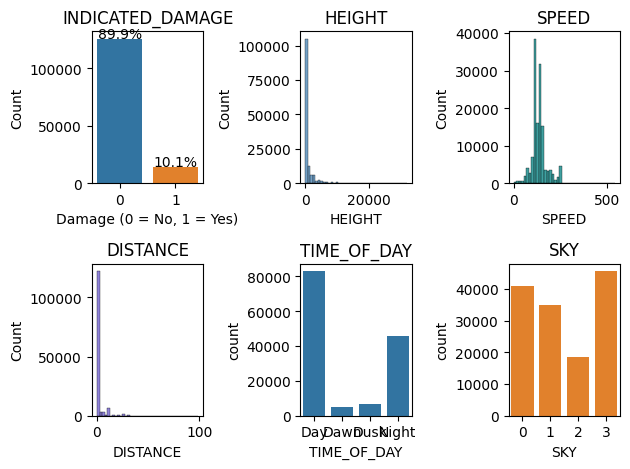

In [50]:
# 1) INDICATED_DAMAGE
plt.subplot(2,3,1)
ax = sns.countplot(
    x='INDICATED_DAMAGE',
    data=aws,
    palette=['C0','C1']
)
plt.title("INDICATED_DAMAGE")
plt.xlabel("Damage (0 = No, 1 = Yes)")
plt.ylabel("Count")

total = len(aws)
for p in ax.patches:
    count = p.get_height()
    pct = count / total * 100 if total else 0
    x = p.get_x() + p.get_width() / 2
    y = count + max(total * 0.005, 1)
    ax.text(x, y, f"{pct:.1f}%", ha='center')

# 2) HEIGHT
plt.subplot(2,3,2)
sns.histplot(aws['HEIGHT'], bins=40, color='steelblue')
plt.title("HEIGHT")

# 3) SPEED
plt.subplot(2,3,3)
sns.histplot(aws['SPEED'], bins=40, color='teal')
plt.title("SPEED")

# 4) DISTANCE
plt.subplot(2,3,4)
sns.histplot(aws['DISTANCE'], bins=40, color='slateblue')
plt.title("DISTANCE")

# 5) TIME_OF_DAY
plt.subplot(2,3,5)
labels = ['Day','Dawn','Dusk','Night']
sns.countplot(x='TIME_OF_DAY', data=aws, color='C0')
plt.xticks(range(4), labels)
plt.title("TIME_OF_DAY")

# 6) SKY
plt.subplot(2,3,6)
sns.countplot(x='SKY', data=aws, color='C1')
plt.title("SKY")

plt.tight_layout()
plt.show()

#### 4.3.4 – Correlation Heatmap

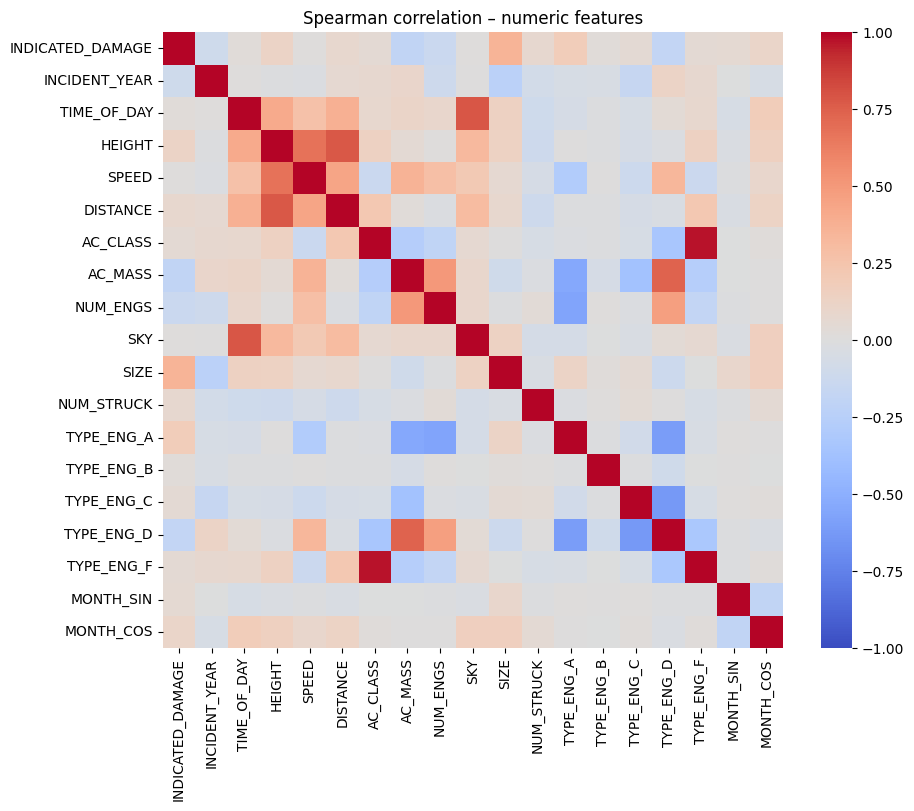

In [51]:
num_cols = aws.select_dtypes(include=['int64','float64']).columns
plt.figure(figsize=(10,8))
sns.heatmap(aws[num_cols].corr(method='spearman'), cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Spearman correlation – numeric features")
plt.show()

### 4.4 - Train/Test Split
___

In [52]:
y = aws['INDICATED_DAMAGE']
X = aws.drop(columns='INDICATED_DAMAGE')

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

print("=== Train/Test Split (80/20)===",
      "\nX_train:", X_train.shape,
      "\ny_train pos:", y_train.sum(),
      "\nX_test:",  X_test.shape,
      "\ny_test pos:",  y_test.sum())

=== Train/Test Split (80/20)=== 
X_train: (112012, 18) 
y_train pos: 11344 
X_test: (28003, 18) 
y_test pos: 2836


___
___
## **5 - Models Training**
___
___

In this section, the training of three classification models — Logistic Regression, Random Forest, and XGBoost — was carried out using two dataset variants: the original class distribution and the class-balanced version.

Before modeling, the data was transformed, and the hyperparameters were selected using Optuna (the tuning code is not included in this project).

### 5.1 - Transformations
___

In [53]:
#log1p for HEIGHT and DISTANCE
for col in ['HEIGHT', 'DISTANCE']:
    X_train[col] = np.log1p(X_train[col])
    X_test[col]  = np.log1p(X_test[col])

#Train sets for Linear Model
num_cols = X_train.select_dtypes('number').columns
scaler   = RobustScaler().fit(X_train[num_cols])

X_train_lin = X_train.copy()
X_test_lin  = X_test.copy()
X_train_lin[num_cols] = scaler.transform(X_train_lin[num_cols])
X_test_lin[num_cols]  = scaler.transform(X_test_lin[num_cols])

#Train sets for Tree Models
X_train_tree = X_train.copy()
X_test_tree  = X_test.copy()

print("Shapes  –  lin:", X_train_lin.shape, "| tree:", X_train_tree.shape)


Shapes  –  lin: (112012, 18) | tree: (112012, 18)


### 5.2 - Helpers
___

In [54]:
cv = StratifiedKFold(5, shuffle=True, random_state=42)

def fit_model(model, X, y, tag):
    """Quick 5-fold snapshot (F1 / Prec / Rec)."""
    f1s, ps, rs = [], [], []
    for tr, va in tqdm(cv.split(X, y), total=5, desc=f"{tag} CV"):
        model.fit(X.iloc[tr], y.iloc[tr])
        p = model.predict(X.iloc[va])
        f1s.append(f1_score(y.iloc[va], p))
        ps.append(precision_score(y.iloc[va], p))
        rs.append(recall_score(y.iloc[va], p))
    print(f"{tag:<10} – F1 {np.mean(f1s):.3f}  P {np.mean(ps):.3f}  R {np.mean(rs):.3f}")

PRED = {}

### 5.3 - Models using the original distribution
___

#### 5.3.1 – Logistic Regression

In [55]:
lr = LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42)
fit_model(lr, X_train_lin, y_train, "LogReg")
lr.fit(X_train_lin, y_train)
PRED['LogReg'] = lr.predict(X_test_lin)

LogReg CV:   0%|          | 0/5 [00:00<?, ?it/s]

LogReg     – F1 0.354  P 0.641  R 0.244


#### 5.3.2 – Random Forest

In [56]:
rf = RandomForestClassifier(n_estimators=400, min_samples_leaf=2,
                            n_jobs=-1, random_state=42)
fit_model(rf, X_train_tree, y_train, "RF")
rf.fit(X_train_tree, y_train)
PRED['RF'] = rf.predict(X_test_tree)

RF CV:   0%|          | 0/5 [00:00<?, ?it/s]

RF         – F1 0.406  P 0.663  R 0.293


#### 5.3.3 – XGBoost

In [57]:
xgb = XGBClassifier(n_estimators=400, max_depth=12, learning_rate=0.05,
                    subsample=0.8, colsample_bytree=0.8,
                    objective='binary:logistic', eval_metric='logloss',
                    scale_pos_weight=1,
                    n_jobs=-1, random_state=42)
fit_model(xgb, X_train_tree, y_train, "XGB")
xgb.fit(X_train_tree, y_train)
PRED['XGB'] = xgb.predict(X_test_tree)

XGB CV:   0%|          | 0/5 [00:00<?, ?it/s]

XGB        – F1 0.414  P 0.608  R 0.314


### 5.4 - Models using the balanced distribution
___

#### 5.4.1 – Logistic Regression

In [58]:
lr_b = LogisticRegression(class_weight='balanced',
                          max_iter=1000, n_jobs=-1, random_state=42)
fit_model(lr_b, X_train_lin, y_train, "LogReg_bal")
lr_b.fit(X_train_lin, y_train)
PRED['LogReg_bal'] = lr_b.predict(X_test_lin)

LogReg_bal CV:   0%|          | 0/5 [00:00<?, ?it/s]

LogReg_bal – F1 0.408  P 0.280  R 0.748


#### 5.4.2 – Random Forest

In [59]:
rf_b = RandomForestClassifier(n_estimators=400, min_samples_leaf=2,
                              class_weight='balanced',
                              n_jobs=-1, random_state=42)
fit_model(rf_b, X_train_tree, y_train, "RF_bal")
rf_b.fit(X_train_tree, y_train)
PRED['RF_bal'] = rf_b.predict(X_test_tree)

RF_bal CV:   0%|          | 0/5 [00:00<?, ?it/s]

RF_bal     – F1 0.480  P 0.506  R 0.457


#### 5.4.3 – XGBoost

In [60]:
spw = y_train.value_counts()[0] / y_train.value_counts()[1]
xgb_b = XGBClassifier(n_estimators=600, max_depth=12, learning_rate=0.05,
                      subsample=0.8, colsample_bytree=0.8,
                      objective='binary:logistic', eval_metric='logloss',
                      scale_pos_weight=spw,
                      n_jobs=-1, random_state=42)
fit_model(xgb_b, X_train_tree, y_train, "XGB_bal")
xgb_b.fit(X_train_tree, y_train)
PRED['XGB_bal'] = xgb_b.predict(X_test_tree)

XGB_bal CV:   0%|          | 0/5 [00:00<?, ?it/s]

XGB_bal    – F1 0.440  P 0.430  R 0.451


___
___
## **6 - Evaluation and Conclusions**
___
___

### 6.1 - Metrics: accuracy, precision, recall, F1-score

In [61]:
metrics = pd.DataFrame({
    name: {
        'accuracy':  accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall':    recall_score(y_test, y_pred),
        'f1':        f1_score(y_test, y_pred)
    }
    for name, y_pred in PRED.items()
}).T.round(3)

ordered_idx = ["LogReg", "LogReg_bal", "RF", "RF_bal", "XGB", "XGB_bal"]

metrics = metrics.reindex(ordered_idx)

display(metrics)

,accuracy,precision,recall,f1
LogReg,0.910,0.642,0.245,0.355
LogReg_bal,0.773,0.273,0.747,0.400
RF,0.912,0.651,0.281,0.393
RF_bal,0.897,0.491,0.455,0.473
XGB,0.908,0.593,0.301,0.400
XGB_bal,0.879,0.409,0.445,0.426


### 6.2 - Confusion matrix

In [62]:
models = ["LogReg","RF","XGB","LogReg_bal","RF_bal","XGB_bal"]
cols = {
    "col_header": "#66C2A5",
    "row_header": "#FC8D62",
    "border":     "#1f2e68",
    "text":       "#1f2e68"
}

fig = make_subplots(
    rows=2, cols=3,
    subplot_titles=models,
    specs=[[{"type":"table"}]*3, [{"type":"table"}]*3],
    vertical_spacing=0.1,
    horizontal_spacing=0.05
)

for idx, m in enumerate(models):
    cm = confusion_matrix(y_test, PRED[m])
    tn, fp = cm[0]
    fn, tp = cm[1]
    r, c = divmod(idx, 3)

    fig.add_trace(
        go.Table(
            header=dict(
                values=["", "<b>Pred 0</b>", "<b>Pred 1</b>"],
                fill_color=[cols["col_header"]]*3,
                font=dict(family="Arial Black", size=14, color=cols["border"]),
                align="center",
                height=30,
                line_color=cols["border"], line_width=2
            ),
            cells=dict(
                values=[
                    ["<b>True 0</b>", "<b>True 1</b>"],
                    [tn, fn],
                    [fp, tp]
                ],
                fill_color=[
                    [cols["row_header"], cols["row_header"]],
                    ["white","white"],
                    ["white","white"]
                ],
                font=dict(
                    family="Arial Black",
                    size=12,
                    color=[
                        [cols["border"], cols["border"]],
                        [cols["text"],   cols["text"]],
                        [cols["text"],   cols["text"]]
                    ]
                ),
                align="center",
                height=30,
                line_color=cols["border"], line_width=2
            )
        ),
        row=r+1, col=c+1
    )

fig.update_layout(
    template="plotly_white",
    title_text="Confusion Matrices",
    title_font=dict(family="Arial Black", size=26, color=cols["border"]),
    title_x=0.5,
    height=400, width=1280,
    margin=dict(t=100, l=20, r=20, b=20)
)

for ann in fig.layout.annotations:
    if ann.text in models:
        ann.font.family = "Arial Black"
        ann.font.size = 16

fig.show()

### 6.3 - Model comparison: original vs. balanced

In [63]:
pairs = [("LogReg", "LogReg_bal"),
         ("RF",     "RF_bal"),
         ("XGB",    "XGB_bal")]
metrics_to_plot = ["accuracy", "precision", "recall", "f1"]

fig_cmp = make_subplots(
    rows=1, cols=3,
    subplot_titles=[orig for orig, _ in pairs],
    shared_yaxes=True,
    horizontal_spacing=0.08
)

col_unbal = "#1f77b4"
col_bal    = "#ff7f0e"

for i, (unbal, bal) in enumerate(pairs, start=1):
    y_u = metrics.loc[unbal, metrics_to_plot]
    y_b = metrics.loc[bal,  metrics_to_plot]

    fig_cmp.add_trace(
        go.Bar(
            x=metrics_to_plot,
            y=y_u,
            marker_color=col_unbal,
            name="Original",
            showlegend=(i == 1)
        ),
        row=1, col=i
    )

    fig_cmp.add_trace(
        go.Bar(
            x=metrics_to_plot,
            y=y_b,
            marker_color=col_bal,
            name="Balanced",
            showlegend=(i == 1)
        ),
        row=1, col=i
    )

fig_cmp.update_layout(
    template="plotly_white",
    barmode="group",
    title_text="Performance Metrics — Original vs Balanced",
    title_font=dict(size=26, family="Arial Black"),
    title_x=0.5,
    title_y=0.95,
    height=550,
    width=1380,
    yaxis_title="Score",
    margin=dict(t=160, l=40, r=40, b=40),
    font=dict(size=14, family="Arial Black"),
    showlegend=True,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.12,
        xanchor="center",
        x=0.5,
        bgcolor="rgba(255,255,255,0.8)",
        bordercolor="black",
        borderwidth=1,
        font=dict(size=12, family="Arial Black")
    )
)

for idx in range(1, 4):
    fig_cmp.update_xaxes(
        tickangle=-30,
        tickfont=dict(size=12, family="Arial Black"),
        row=1, col=idx
    )
    fig_cmp.update_yaxes(
        tickfont=dict(size=12, family="Arial Black"),
        row=1, col=idx
    )

for ann in fig_cmp.layout.annotations[:3]:
    ann.font.size = 16
    ann.font.family = "Arial Black"

fig_cmp.show()

### 6.4 - Conclusions

In experiments comparing three classifiers trained with and without a re-balanced target, the following was observed:

- **Recall increased significantly** (by 14–50 percentage points).  
  > Re-balancing allowed each model to capture many more true positives and miss far fewer cases.

- **Precision and overall accuracy decreased**.  
  > Casting a wider net produced more false positives, lowering the proportion of correct positive predictions.

- **F1-score improved across all models** (by 0.03–0.07).  
  > The gain in recall outweighed the drop in precision, yielding a stronger balance between sensitivity and specificity.

- **Balanced Random Forest delivered the best compromise** (F1 ≈ 0.47).  
  > It achieved higher recall with only a small loss in accuracy, ending up with the top overall F1.

- **Re-balancing is most useful when missing a positive is costlier than a false alarm** (e.g., safety alerts, fraud detection, medical screening).  
  > If false positives carry a higher penalty, it may be better to retain the original class distribution.






